## 組合せ最適化問題
量子コンピュータで最適化問題を解くには、イジングモデルといわれる物理モデルを利用する。

## QUBO定式化
QUBOは問題の答えが小さいほうが正解になるように設定された式です。式の形は、

$$
QUBO = -\sum_i h_i q_i -\sum_{i,j}J_{ij}q_iq_j
$$

となっている。iとjは点を表し、hはバイアス（局所磁場）、Jは相互作用と呼ばれます。この式ではqは量子ビットを表し0か1を取ります（イジングの場合は+1か-1）。
私たちはhとJを問題として設定し、qの値を求めます。

## 問題設定の仕方
問題の設定の仕方は、グラフ問題というものに問題を落とすことで計算できますが、いくつか問題を解くことでコツをつかめます。

主に問題のコスト関数は二種類の式を考える必要があります。

１．小さくしたいコスト関数  
２．満たすべき条件（制約条件）

この二つを別々に設計し、つなげることで実装できます。片方しかない式もあります。

## 使うツール

networkx（ネットワークグラフを書く）  
matplotlib（各種のグラフを書く）  
numpy（数値ライブラリ）  

In [1]:
!pip install --quiet networkx matplotlib

## 4-1. クリーク判定問題
クリークとは, 頂点同士がすべてつながっている頂点群を言います。

クリーク問題は、グラフ $G=(V,E)$ の部分集合 $W \in V$ において、大きさ $|W| = K$ のあらゆる2点を繋ぐ$\frac{K(K-1)}{2}$個の辺があるかどうかを判定します。

### QUBO式
考えるイジング式は, グラフの大きさが$K$になる式と、辺の数が$\frac{K(Kー1)}{2}$個になる場合の2個を足します. 

1. 部分集合のサイズが$K$個ある条件式

$$ C_1 = ( K - \sum_{v\in V} q_v) ^ 2 $$

2. あらゆる2点をつなぐ辺の数が $\frac{K(K-1)}{2}$ある条件式

$$ C_2 = \frac{K(K-1)}{2} - \sum_{u,v \in E} q_uq_v $$

求めるイジング式はこの2つを足します. 

### 問題設定
下記のような４点の問題を考えます。クリークがあるところの頂点がすべて1に、それ以外が0になります。

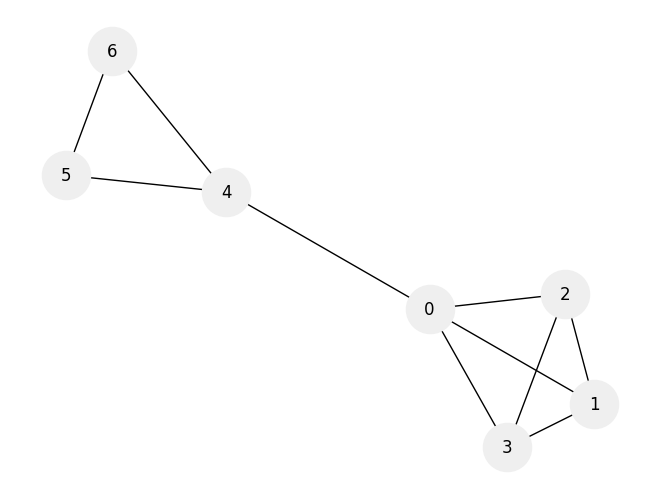

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

#頂点数
n = 7

#探すクリーク数
K = 4

G = nx.Graph()
G.add_nodes_from(nx.path_graph(n))

G.add_edges_from([(0,1),(0,2),(0,3),(0,4),(1,2),(1,3),(2,3),(4,6),(4,5),(5,6)])
nx.draw(G, **options)

In [20]:
from tytan import *
import sympy as sym

# 変数を定義
q = sym.symbols("q_{0:7}")
    
#一つ目の式を準備
C_1 = (K - sum(q))**2

#二つ目の式を準備
C_2 = K*(K-1)/2 - sum(q[k[0]]*q[k[1]] for k in G.edges)

#式をつなげます。
H = C_1*10 + C_2

# Compileクラスを使用して、QUBOを取得
Q, offset = qubo.Compile(H).get_qubo()

#print(Q)

# サンプラーを選択
solver = sampler.SASampler()

#クラウドサンプラーの場合
#API_KEY = "API key"
#solver = sampler.NQSSampler()
#result = solver.run(Q, api_key=API_KEY)

# 計算
result = solver.run(Q, shots=100)

print("Sample =", result[0][0])
print("Cost =", result[0][1] + offset)

Sample = {'q_{0}': 1.0, 'q_{1}': 1.0, 'q_{2}': 1.0, 'q_{3}': 1.0, 'q_{4}': 0.0, 'q_{5}': 0.0, 'q_{6}': 0.0}
Cost = 0


頂点0,1,2,3に大きさ4のクリークを見つけられました。

## 4-2. Clique Cover
与えられたグラフを$N$個のクリークに色を割り当てることが出来るかどうか求める問題. 

### QUBO式
頂点 $v$ が色 $i$ のときのビット変数を $x_{v,i}$とします.

1. 頂点が一つの色を持つ条件
2. 色の合計が$N$になる条件

$ \displaystyle H = A \sum_v \left( 1 - \sum_{i = 1}^n x_{v,i} \right)^2 + B \sum_{i=1}^n \left[ \frac {1}{2} \left( -1 + \sum_v x_{v,i} \right) \sum_v x_{v,i} - \sum_{(uv) \in E} x_{u,i}x_{v.i} \right]$

### 問題設定
下記のような５点の問題を考えます。

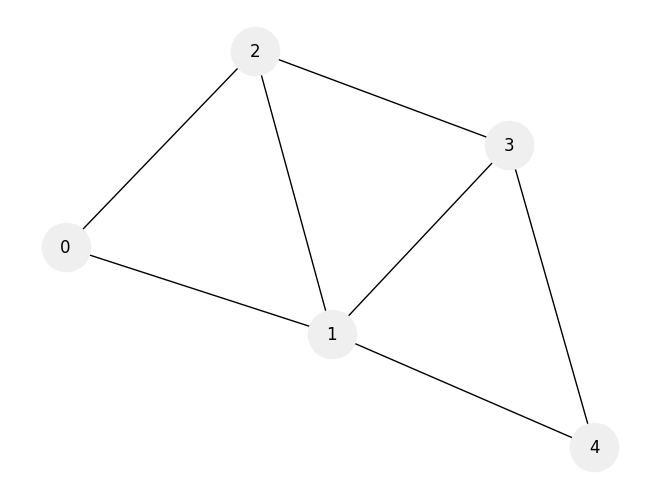

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

N = 5

G = nx.Graph()
G.add_nodes_from(nx.path_graph(N))
G.add_edges_from([(0,1),(0,2),(1,2),(1,3),(1,4),(2,0),(2,3),(3,4)])
nx.draw(G, **options)

In [22]:
from tytan import *
import sympy as sym
import numpy as np

n_color = 2
graph_size = N
q_size = n_color*graph_size

# 変数を定義
q = sym.symbols("q_{0:10}")

#隣接行列
A = nx.to_numpy_matrix(G)
print(A)

[[0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1.]
 [1. 1. 0. 1. 0.]
 [0. 1. 1. 0. 1.]
 [0. 1. 0. 1. 0.]]


In [23]:
A=0.1
B=0.1

#式A
HA = 0
for v in range(graph_size):
    sum_x = 0
    for i in range(n_color):
        index = v * n_color + i
        sum_x += q[index]
        HA += (1 - sum_x) ** 2
HA *= A

#式B
HB = 0.0
for i in range(n_color):
    sum_x = 0
    for v in range(graph_size):
        vi = v * n_color + i
        sum_x += q[vi]
        for u in range(graph_size):
            if u >= v:
                continue
                ui = u * n_color + i
                HB -= G[u][v] * q[ui] * q[vi]
        HB += 0.5 * (-1 + sum_x) * sum_x
    HB *= B

#式をつなげます。
H = HA + HB

In [25]:
# Compileクラスを使用して、QUBOを取得
Q, offset = qubo.Compile(H).get_qubo()

#print(Q)

# サンプラーを選択
solver = sampler.SASampler()

#クラウドサンプラーの場合
#API_KEY = "API key"
#solver = sampler.NQSSampler()
#result = solver.run(Q, api_key=API_KEY)

# 計算
result = solver.run(Q, shots=100)

print("Sample =", result[0][0])
print("Cost =", result[0][1] + offset)

Sample = {'q_{0}': 1.0, 'q_{1}': 0.0, 'q_{2}': 1.0, 'q_{3}': 0.0, 'q_{4}': 1.0, 'q_{5}': 0.0, 'q_{6}': 1.0, 'q_{7}': 0.0, 'q_{8}': 1.0, 'q_{9}': 0.0}
Cost = 0.200000000000000


## 4-3.厳密被覆問題(EXACT COVER PROBLEM)
集合 $ U = {1,....,n}$の部分集合 $V_i \in U \{1,....,n\}$. のうち任意の部分集合の和集合が$U$であるようなものがあるかどうか.

$U=1,2,3$  
$V1=1,2$  
$V2=1$  
$V3=3$  


### イジング式
バイナリ変数 $x_i$ が $1$のときに部分集合 $V_i$ に含まれるとする.
考えるイジング式は,  $x_i$が$1$のときの部分集合$V_i$の和が集合$U$の要素とちょうど同じになるときを考える. 

$$ H = A \sum_{\alpha=1}^{n} ( 1 - \sum_{i:\alpha\in V_i} x_i)^2$$

### 問題設定

In [26]:
from tytan import *
import sympy as sym
import numpy as np

graph_size = 3
q_size = graph_size

# 変数を定義
q = sym.symbols("q_{0:3}")

U = np.array([1, 2, 3])
V_size = 3

V = np.array([[1,2],[1],[3]],dtype=object)

H = 0.0
temp = 0.0
for i in range(U.size):
    for j in range(V.size):
        if((np.where(V[j] == U[i]))[0].size > 0):
            temp+= q[j]
    H+= (1 - temp)**2
    temp = 0.0
    
H = 10 * H

U = np.array([1, 2, 3])
V_size = 3

V = np.array([[1,2],[1],[3]],dtype=object)

H = 0.0
temp = 0.0
for i in range(U.size):
    for j in range(V.size):
        if((np.where(V[j] == U[i]))[0].size > 0):
            temp+= q[j]
    H+= (1 - temp)**2
    temp = 0.0
    
# Compileクラスを使用して、QUBOを取得
Q, offset = qubo.Compile(H).get_qubo()

#print(Q)

# サンプラーを選択
solver = sampler.SASampler()

#クラウドサンプラーの場合
#API_KEY = "API key"
#solver = sampler.NQSSampler()
#result = solver.run(Q, api_key=API_KEY)

# 計算
result = solver.run(Q, shots=100)

print("Sample =", result[0][0])
print("Cost =", result[0][1] + offset)

Sample = {'q_{0}': 1.0, 'q_{1}': 0.0, 'q_{2}': 1.0}
Cost = 0
